<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" />
    
    
### <font color='navy'> Modelos no lineales para pronósticos.

**Nombres:**
- Judith Alejandra Hinojosa Rábago
- Kaleb Azael Ávila Padilla

**Fecha:** 15 de febrero del 2024.

**Expediente** :
- 737456
- 724405

**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: [https://github.com/judith-ale/ProyectoConjunto_JAHinojosa_KAAvila](https://github.com/judith-ale/ProyectoConjunto_JAHinojosa_KAAvila)

# Tarea 3: Clase 7

## Enunciado de tarea

Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado. Algo como lo siguiente:

```
class LinearForecast:
    def __init__(self, atributos_del_contructor):
        
    def adf_test(self):
        
    def plot_acf_pac(self):
        
        .
        .
        .
```


Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase.

Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente [conjunto de datos](https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true
).

### Ejercicio 1: Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado. Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase.

#### Estudiante 1: Judith Alejandra Hinojosa Rábago

In [1]:
import pandas as pd
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import MSTL

from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import statsmodels as st

import itertools

from sklearn.preprocessing import power_transform

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest


# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Código de solución estudiante 1
class LinearForecast:
    """Flujo de datos para realizar un forecast

    Attributes:
        timeseries (pandas.DataFrame): [Serie de tiempo]
        x_label (str): [Etiqueta del eje x]
        y_label (str): [Etiqueta del eje y]
        sarimax_params (list): [Lista de combinación de parámetros del modelo SARIMAX]
        scaler (sklearn.Scaler): [Escalador de datos]
    """
    # lectura de datos
    def __init__(self, timeseries, x_label='Time', y_label='Value'):
        """Constructor que lee los datos directamente

        Lee los datos como un DataFrame de pandas
        
        Parameters
        ----------
        timeseries : pandas.DataFrame
            Datos en formato DataFrame.
        x_label : str [optional, default='Time']
            Nombre de la etiqueta x_label.
        y_label : str [optional, default='Value']
            Nombre de la etiqueta y_label."""
        
        self.x_label = x_label
        self.y_label = y_label
        self.timeseries = timeseries
    
    def set_x_label(self, x_label='Time'):
        """Actualiza el valor del atributo x_label
        
        Parameters
        ----------
        x_label : str [optional, default='Time']
            Nombre de la etiqueta x_label"""
        self.x_label = x_label

    def set_y_label(self, y_label='Value'):
        """Actualiza el valor del atributo y_label
        
        Parameters
        ----------
        y_label : str [optional, default='Value']
            Nombre de la etiqueta y_label"""
        self.y_label = y_label

    def split_dataset(self, timeseries=None, train_size=0.8):
        """Separa la serie de tiempo en train y test
        
        Parameters
        ----------
        timeseries : pandas.DataFrame [optional, default=LinearForecast.timeseries]
            La serie de tiempo a separar.
        train_size : float [optional, default=0.8]
            Número de [0, 1] que representa el porcentaje de datos para el dataset de entrenamiento.
            
        Returns
        ----------
        tuple(pandas.DataFrame, pandas.DataFrame) con los datos en train y test respectivamente"""

        if timeseries is None:
            timeseries = self.timeseries

        i = int(timeseries.shape[0]*train_size)
        
        train = timeseries[:i]
        test = timeseries[i:]
        return train, test
        
    # Análisis
    def adf_test(self, timeseries=None) -> None:
        """Visualiza los resultados de la prueba de Dickey-Fuller
        
        Parameters
        ----------
        timeseries : pandas.DataFrame [optional, default=LinearForecast.timeseries]
            La serie de tiempo a evaluar"""
        
        if timeseries is None:
            timeseries = self.timeseries
            
        print("Results of Dickey-Fuller Test:")
        dftest = adfuller(timeseries, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)
        
        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")

    
    def plot_acf_pacf(self, timeseries=None, **kwargs) -> None:
        """Visualiza autocorrelación y autocorrelación parcial

        Parameters
        ----------
        timeseries : pandas.DataFrame [optional, default=LinearForecast.timeseries]
            La serie de tiempo a graficar
        **kwargs : dict [optional, default=dict]
            Argumentos extra para los métodos de plot_acf y plot_pacf."""
        
        if timeseries is None:
            timeseries = self.timeseries
        
        f = plt.figure(figsize=(8,5))

        # Autocorrelación
        ax1 = f.add_subplot(121)
        plot_acf(timeseries, zero=False, ax=ax1, **kwargs)

        # Autocorrelación parcial
        ax2 = f.add_subplot(122)
        plot_pacf(timeseries, zero=False, ax=ax2, method='ols', **kwargs)
    
        plt.show()

    def plot_timeseries(self, timeseries=None, **kwargs) -> None:
        """Visualiza la serie de tiempo

        Parameters
        ----------
        timeseries : pandas.DataFrame [optional, default=LinearForecast.timeseries]
            La serie de tiempo a gráficar
        **kwargs : dict [optional, default=dict]
            Argumentos extra para el método de plot."""
        
        if timeseries is None:
            timeseries = self.timeseries
            
        timeseries.plot(**kwargs) # pasamos los argumentos
        plt.xlabel(self.x_label)
        plt.ylabel(self.y_label)
        plt.show()


    def decompose(self, timeseries=None, periods_seasonality=(12,)) -> None:
        """Descompone la serie de tiempo

        Descompone la serie de tiempo con el método Multiple Seasonal-Trend decomposition

        Parameters
        ----------
        timeseries : pandas.DataFrame [optional, default=LinearForecast.timeseries]
            La serie de tiempo a descomponer.
        periods_seasonality : tuple(int) [optional, default=(12,)]
            Los periodos estacionales en los cuales se descompondrá la serie"""

        if timeseries is None:
            timeseries = self.timeseries
            
        stl_kwargs = {"seasonal_deg": 0} 
        model = MSTL(timeseries, periods=periods_seasonality, stl_kwargs=stl_kwargs)
        
        return model.fit()

        
    def plot_decomposition(self, timeseries=None, periods_seasonality=(12,)) -> None:
        """Visualiza la serie de tiempo y sus componentes

        Visualización de la serie de tiempo, su tendencia, estacionalidad y residuos.

        Parameters
        ----------
        timeseries : pandas.DataFrame [optional, default=LinearForecast.timeseries]
            La serie de tiempo a gráficar.
        periods_seasonality : tuple(int) [optional, default=(12,)]
            Los periodos estacionales en los cuales se descompondrá la serie"""

        if timeseries is None:
            timeseries = self.timeseries
            
        data1 = timeseries.copy()
        
        res2 = self.decompose(data1, periods_seasonality)
        
        # Gráfica de descomposición
        fig, ax = plt.subplots(len(periods_seasonality) + 3, 1, sharex=True, figsize=(8, 8))

        plt.xlabel(self.x_label)
        
        res2.observed.plot(ax=ax[0])
        ax[0].set_ylabel('Observado')
        
        res2.trend.plot(ax=ax[1])
        ax[1].set_ylabel('Tendencia')

        if len(periods_seasonality) == 1:
            i = 0
            res2.seasonal.plot(ax=ax[2 + i])
            ax[2].set_ylabel('Estaciconal')
        else: 
            for i in range(len(periods_seasonality)):
                res2.seasonal[f'seasonal_{periods_seasonality[i]}'].plot(ax=ax[2 + i])
                ax[2 + i].set_ylabel(f'Estaciconal_{periods_seasonality[i]}')
        
        res2.resid.plot(ax=ax[3 + i])
        ax[3 + i].set_ylabel('Residuos')
        
        fig.tight_layout()


    def transform(self, timeseries=None, method = 'log'):
        """Transforma la serie de tiempo

        Transforma la serie de tiempo con el método especificado.

        Parameters
        ----------
        timeseries : pandas.DataFrame [optional, default=LinearForecast.timeseries]
            La serie de tiempo a transformar.
        method : str [optional, default='log']
            El método a utilizar para transformar:'log', 'sqrt', 'box-cox', 'yeo-johnson', 
            'min_max_scaler' o 'standard_scaler'.
            
        Returns
        ----------
        pandas.DataFrame de los datos transformados con el método especificado
        """

        if timeseries is None:
            timeseries = self.timeseries

        timeseries = timeseries.copy()
        
        if method == 'log':    
            return np.log(timeseries - timeseries.min() + 1)
        elif method == 'sqrt':
            return np.sqrt(timeseries)
        elif method == 'box-cox' or method == 'yeo-johnson':
            vals = power_transform(timeseries.iloc[:, 0].to_numpy().reshape(-1, 1), method=method)
            timeseries.iloc[:, 0] = vals.squeeze()
            return timeseries
        elif method == 'min_max_scaler':
            scaler = MinMaxScaler()
            vals = scaler.fit_transform(timeseries.iloc[:, 0].to_numpy().reshape(-1, 1))
            timeseries.iloc[:, 0] = vals
            self.scaler = scaler # Guarda el escalador para su posterior uso
            return timeseries
        elif method == 'standard_scaler':
            scaler = StandardScaler()
            vals = scaler.fit_transform(timeseries.iloc[:, 0].to_numpy().reshape(-1, 1))
            timeseries.iloc[:, 0] = vals
            self.scaler = scaler # Guarda el escalador para su posterior uso
            return timeseries
        else:
            raise Exception("Método no especificado")

    def test_normality(self, timeseries=None, threshold=0.05):
        """Evalua la normalidad de la distribución de los datos

        Parameters
        ----------
        timeseries : pandas.DataFrame [optional, default=LinearForecast.timeseries]
            La serie de tiempo a evaluar.
        threshold : float [optional, default=0.05]
            Valor a partir del cual no la consideramos normal
            
        Returns
        ---------
        Valor booleano, False si no es normal, True si sí se considera normal"""
        if timeseries is None:
            timeseries = self.timeseries
            
        if(normaltest(timeseries)[1] < threshold):
            return False
        return True

    def plot_distribution(self, timeseries=None, **kwargs):
        """Visualiza la distribución de los datos de la serie de tiempo

        Parameters
        ----------
        timeseries : pandas.DataFrame [optional, default=LinearForecast.timeseries]
            La serie de tiempo a gráficar
        **kwargs : dict [optional, default=dict]
            Argumentos extra para el método de plot."""

        if timeseries is None:
            timeseries = self.timeseries
            
        fig, ax = plt.subplots(1, 2, **kwargs)

        timeseries.hist(bins=50, ax=ax[0])
        
        timeseries.boxplot(ax=ax[1])

        plt.show()

    # Ajuste de parámetros
    def combine_parameters(self, p, d, q, P, D, Q, S, t):
        """Crea una combinación de posibles parámetros

        Genera una combinación con posibles valores de parámetros para un modelo SARIMAX

        Parameters
        ----------
        p : tuple(int)
            Parte autorregresiva de la parte no estacional de la serie de tiempo.
        d : tuple(int)
            Número de veces que se diferencia la parte no estacional de la serie de tiempo.
        q : tuple(int)
            Parte de medias móviles de la parte no estacional de la serie de tiempo.
        P : tuple(int)
            Parte autorregresiva de la parte estacional de la serie de tiempo.
        D : tuple(int)
            Número de veces que se diferencia la parte estacional de la serie de tiempo.
        Q : tuple(int)
            Parte de medias móviles de la parte estacional de la serie de tiempo.
        S : tuple(int)
            Estacionalidad de la parte estacional de la serie de tiempo.
        t : tuple(str)
            Tipo de tendencia: 'n', 'c', 't' y 'ct'.
            
        Returns
        ----------
        Lista de posibles combinaciones de los valores"""
    
        # Explorar función itertools.product
        no_estacional = list(itertools.product(p, d, q))
        estacional = list(itertools.product(P, D, Q, S))
        
        # Diferentes conmbinaciones
        self.sarimax_params = list(itertools.product(no_estacional, estacional, t))

        return self.sarimax_params

    def search_best_set_params(self, timeseries=None, sorting='AIC', ascending=True, sarimax_params=None):
        """Evaluación de modelo con las combinaciones del método sarimax_params

        ---Antes de usar se debe correr LinearForecast.sarimax_params---
        Con la combinación de posibles valores de parámetros para un modelo SARIMAX genera
        una tabla de resultados de las métricas AIC, BIC y LLF.

        Parameters
        ----------
        timeseries : pandas.DataFrame [optional, default=LinearForecast.timeseries]
            La serie de tiempo con la que se realiza el modelo.
        sorting : str [optional, default='AIC']
            Con que valor posible entre 'AIC', 'BIC' y 'LLF' desea que se ordene la tabla.
        ascending : bool  [optional, default=True]
            Orden en el que se regresa el DataFrame, True para ascendente y False para descendente.
        sarimax_params : list(tuple, tuple, str) [optional, default=LinearForecast.sarimax_params]
            Lista de parámetros a evaluar
            
        Returns
        ----------
        pandas.DataFrame de resultados con posibles combinaciones"""

        if timeseries is None:
            timeseries = self.timeseries

        if sarimax_params is None:
            sarimax_params = self.sarimax_params
            
        resultados = pd.DataFrame(columns=['params', 'AIC', 'BIC', 'LLF'])

        i=0
        for non_seasonal, seasonal, trend in sarimax_params:
            mod = SARIMAX(
                endog=timeseries,
                trend=trend,
                order=non_seasonal,
                seasonal_order=seasonal
            )
            results = mod.fit(disp=False)
            
            resultados.loc[i, 'params'] = str((non_seasonal, seasonal, trend))
            resultados.loc[i,'AIC'] = results.aic
            resultados.loc[i,'BIC'] = results.bic
            resultados.loc[i,'LLF'] = results.llf
            i += 1
            
        return resultados.sort_values(by=[sorting], ascending=ascending)

    
    def fit(self, timeseries=None, order=(0, 0, 0), seasonal_order=(0, 0, 0), trend='n'):
        """Ajuste de modelo SARIMAX

        Ajusta el modelo con los parámetros especificados y la serie de tiempo.

        Parameters
        ----------
        timeseries : pandas.DataFrame [optional, default=LinearForecast.timeseries]
            La serie de tiempo con la que se realiza el modelo.
        order : tuple(int, int, int) [optional, default=(0, 0, 0)]
            Valores p, d y f para la parte no estacional del modelo.
        seasonal_order : tuple(int, int, int) [optional, default=(0, 0, 0)]
            Valores P, D, F y S para la parte estacional del modelo.
        trend : tuple(str) [optional, default='n']
            Tipo de tendencia: 'n', 'c', 't' y 'ct'.
            
        Returns
        ----------
        Modelo statsmodels.SARIMAX ajustado"""
        if timeseries is None:
            timeseries = self.timeseries
            
        model = SARIMAX(
            endog = timeseries,
            trend = trend,
            order = order,
            seasonal_order = seasonal_order,
            enforce_stationary = True,
            enforce_invertibility = False
        )
        
        results = model.fit()
        
        self.model = results
        
        return results

    # Predicción
    def predict(self, **kwargs):
        """Predicción de valores

        Parameters
        ----------
        **kwargs : dict [optional, default=dict]
            Argumentos para el método get_prediction del modelo
            
        Returns
        ----------
        statsmodels.PredictionResultsWrapper
        """
            
        return self.model.get_prediction(**kwargs)

    def predict_iter(self, timeseries=None, horizon=10, order=(0, 0, 0), seasonal_order=(0, 0, 0), trend='n'):
        """Predicción de modelo SARIMAX de forma iterativa

        Predice la serie de tiempo de forma iterativa a un horizonte al futuro

        Parameters
        ----------
        timeseries : pandas.DataFrame [optional, default=LinearForecast.timeseries]
            La serie de tiempo con la que se realiza el modelo y predicción.
        horizon : int [optional, default=10]
            Cantidad de valores que predecir al futuro.
        order : tuple(int, int, int) [optional, default=(0, 0, 0)]
            Valores p, d y f para la parte no estacional del modelo.
        seasonal_order : tuple(int, int, int) [optional, default=(0, 0, 0)]
            Valores P, D, F y S para la parte estacional del modelo.
        trend : tuple(str) [optional, default='n']
            Tipo de tendencia: 'n', 'c', 't' y 'ct'.
            
        Returns
        ----------
        Lista con valores predichos"""
        if timeseries is None:
            timeseries = self.timeseries

        timeseries = timeseries.copy()

        y_pred = []
        
        for i in range(horizon):
            mod = SARIMAX(
            endog=timeseries,
            trend=trend,
            order=order,
            seasonal_order=seasonal_order
            )
            
            results = mod.fit(disp=False)
            
            prediction = results.predict(timeseries.shape[0])
            timeseries = np.append(timeseries, prediction[0])
            y_pred.append(prediction[0])

        return y_pred


    # Métricas de errores
    def evaluate(self, y, predicted):
        """Evaluación del performance del modelo
        
        Calcula las métricas de error.
        
        Parameters
        ----------
        y : pandas.DataFrame
            La serie de tiempo con los valores reales.
        predicted : pandas.DataFrame
            La serie de tiempo con las predicciones.

        Returns
        ----------
        Diccionario con los resultados de las evaluaciones."""

        sub = (y - predicted).abs()
        
        mape = (sub / y.abs()).mean()
        mad = sub.mean()
        
        return {'MAPE': mape, 'MAD': mad}

#### Estudiante 2: Kaleb Azael Ávila Padilla

In [ ]:
# Código de solución estudiante 2
.
.
.
.


### Ejercicio 2: Utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente [conjunto de datos](https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true).

#### Estudiante 1: Judith Alejandra Hinojosa Rábago

In [4]:
# Código de solución estudiante 1
url = "https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true"
data = pd.read_excel(url)[['date', 'Energy (kWh)']] # Realizamos la obtención de datos, seleccionamos date como temporalidad y Energy (kWh) como nuestra y
data.head()

,date,Energy (kWh)
0,1990-01-01,498.632
1,1990-01-01,720.409
2,1990-01-01,946.154
3,1990-01-01,987.273
4,1990-01-01,1000.230


In [5]:
# De los datos obtenidos seleccionamos la media de energía mensual como variable a predecir.
data = data.set_index('date').resample('M').mean()
data.columns = ['y']
data.head()

,y
date,
1990-01-31,451.887005
1990-02-28,423.897505
1990-03-31,430.298776
1990-04-30,296.197605
1990-05-31,288.352006


In [6]:
data.index = data.index.to_period('M') # Transformamos el periodo a año-mes

In [7]:
data.info() # No hay nulos

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 300 entries, 1990-01 to 2014-12
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       300 non-null    float64
dtypes: float64(1)
memory usage: 4.7 KB


In [8]:
lf = LinearForecast(timeseries=data, x_label='Month-Year', y_label='Mean_Energy') # Inicializamos nuestro objeto LinearForecast

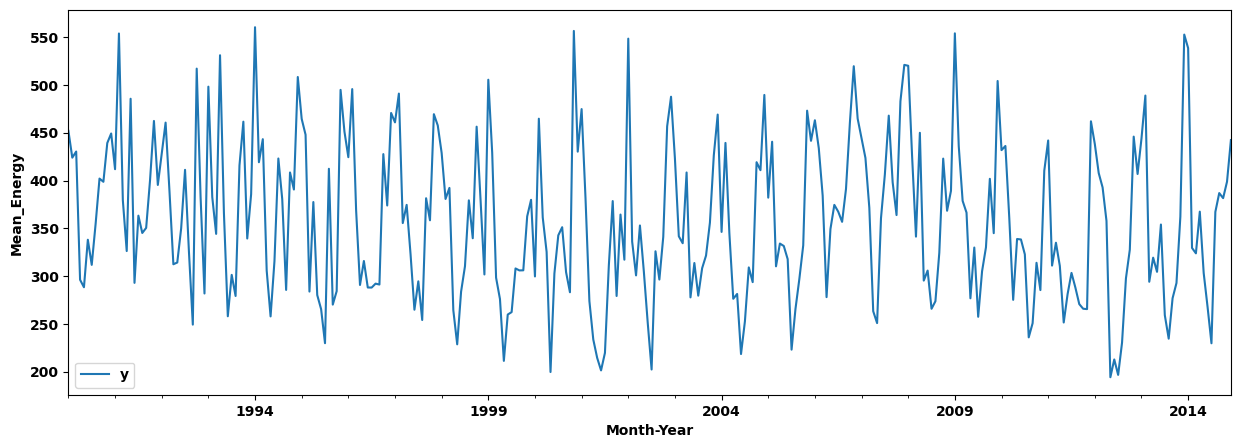

In [9]:
lf.plot_timeseries(data, figsize=(15, 5))

Parece haber cierta estacionalidad anual y no haber tendencia. Pero se tienen que hacer más análisis.

##### Análisis de estacionalidad

###### Autocorrelación

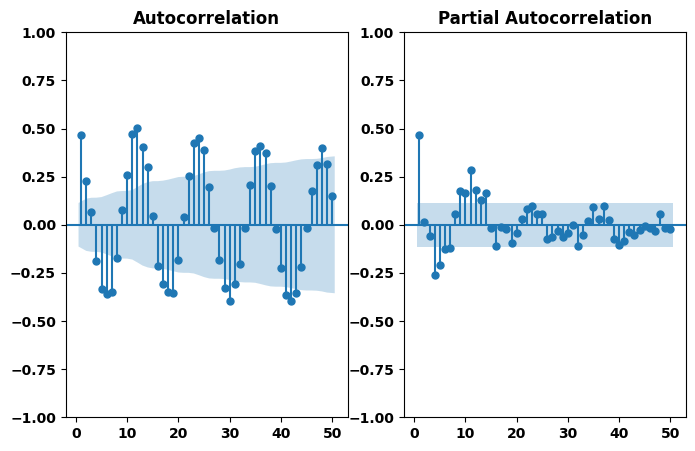

In [10]:
lf.plot_acf_pacf(lags=50)

Se puede observar una autocorrelación y autocorrelación parcial cada 12 meses.

##### Descomposición de la serie de tiempo

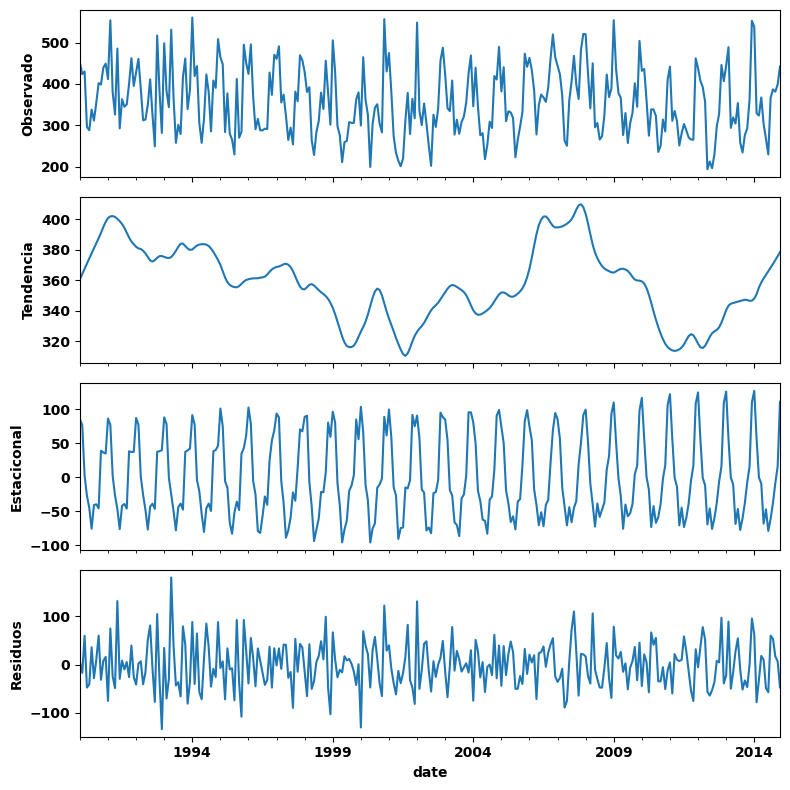

In [11]:
s = lf.plot_decomposition()

Al observar la descomposición se ve que no hay una tendencia clara y hay una estacionalidad anual marcada en la media de la energía mensual.

###### Estacionariedad en la estacionalidad

In [12]:
seasonal_component = lf.decompose().seasonal
lf.adf_test(seasonal_component)

Results of Dickey-Fuller Test:
Test Statistic                -1.211705e+01
p-value                        1.862045e-22
#Lags Used                     1.600000e+01
Number of Observations Used    2.830000e+02
Critical Value (1%)           -3.453670e+00
Critical Value (5%)           -2.871808e+00
Critical Value (10%)          -2.572241e+00
dtype: float64
Stationary


Los datos estacionales son estacionarios.

###### Determinar los parámetros $(P, D, Q, S)$

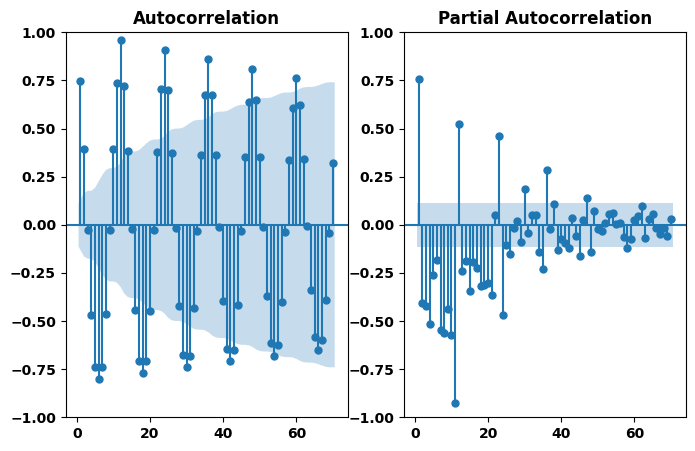

In [13]:
lf.plot_acf_pacf(seasonal_component, lags=70)

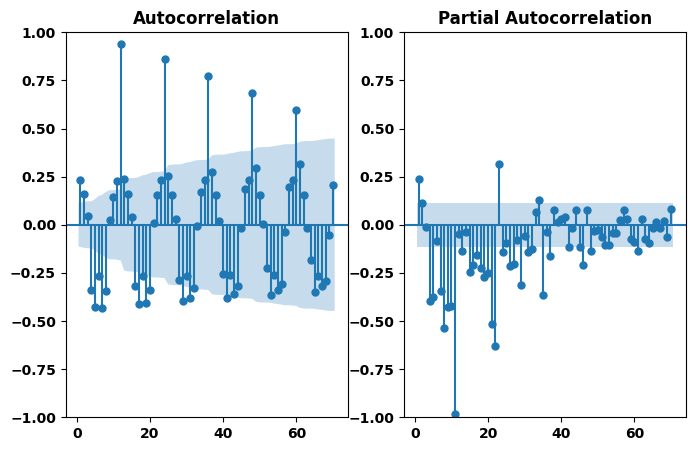

In [14]:
lf.plot_acf_pacf(seasonal_component.diff().dropna(), lags=70)

Parece que los posibles valores de $P$ son $\{1, 2\}$, de $D$ son $\{0, 1\}$ y $Q$ son $\{1, 2\}$ para una $S=12$.

##### Estacionariedad en la no estacionalidad

In [15]:
# Calcular la estacionariedad de mis datos observados
lf.adf_test(data)

Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary


No son estacionarios

In [16]:
# Calcular si la serie no estacional es estacionaria o no
non_seasonal_component = lf.decompose().observed - lf.decompose().seasonal
lf.adf_test(non_seasonal_component)

Results of Dickey-Fuller Test:
Test Statistic                  -2.772887
p-value                          0.062252
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary


No es estacionaria, hay que evaluar la diferenciación.

In [17]:
lf.adf_test(non_seasonal_component.diff().dropna())

Results of Dickey-Fuller Test:
Test Statistic                -7.501920e+00
p-value                        4.231463e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.850000e+02
Critical Value (1%)           -3.453505e+00
Critical Value (5%)           -2.871735e+00
Critical Value (10%)          -2.572202e+00
dtype: float64
Stationary


Diferenciada sí es estacionaria.

###### Autocorrelación

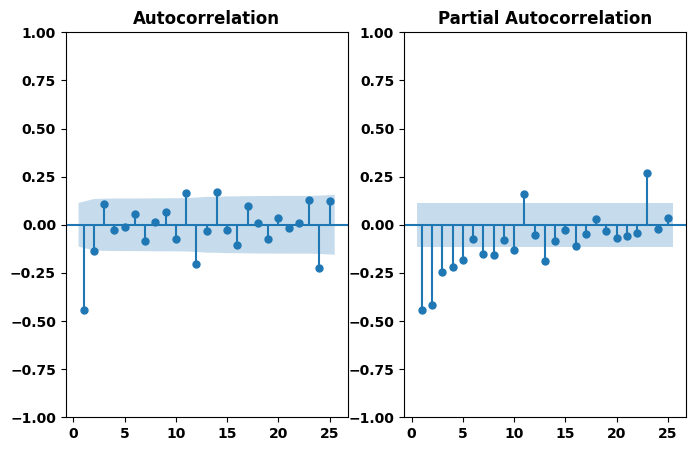

In [18]:
lf.plot_acf_pacf(non_seasonal_component.diff().dropna())

Parece que los posibles valores de $p$ son $\{1, 2\}$, de $d$ es $\{1\}$ y $q$ son $\{0, 1\}$ para la parte no estacional.

In [19]:
ls_params = lf.combine_parameters(p = (0, 1, 2), 
                                  d = (0, 1), 
                                  q = (0, 1), 
                                  P = (0, 1, 2), 
                                  D = (0, 1),
                                  Q = (0, 1, 2), 
                                  S = (12, ),
                                  t = ('n', 'c', 't', 'ct'))

len(ls_params)

864

##### Transformación y escalamiento de los datos

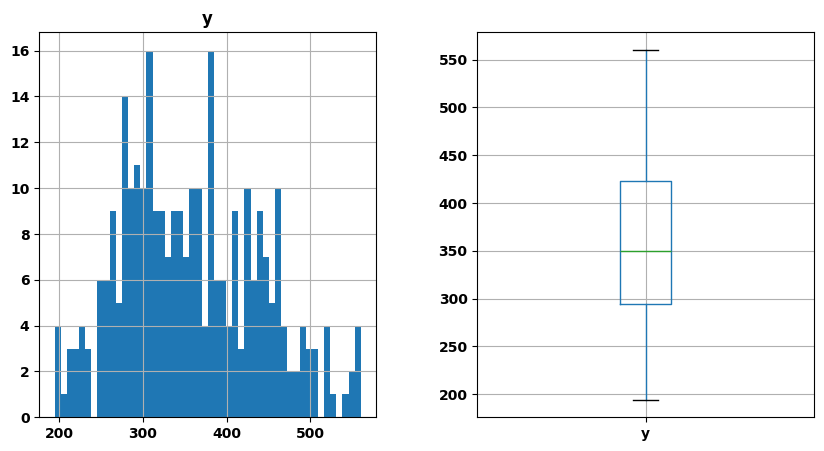

In [20]:
lf.plot_distribution(figsize=(10, 5))

No parece haber outliers por lo que se puede proceder sólo a escalar para eso se dividen los datos en train y test y se escalan conforme a los datos de entrenamiento.

In [21]:
train, test = lf.split_dataset(train_size=0.8) # dividimos en train y test

# escalamos con el StandardScaler
train = lf.transform(train, method="standard_scaler")

test.iloc[:, 0] = lf.scaler.transform(test)

##### Encontramos la mejor combinación de parámetros

In [22]:
res = lf.search_best_set_params(train, sarimax_params=ls_params[240:260])

In [23]:
res

,params,AIC,BIC,LLF
16,"((0, 1, 1), (1, 1, 1, 12), 'n')",542.7035,556.4033,-267.35175
17,"((0, 1, 1), (1, 1, 1, 12), 'c')",543.110177,560.234927,-266.555089
4,"((0, 1, 1), (1, 0, 1, 12), 'n')",578.230309,592.136163,-285.115154
8,"((0, 1, 1), (1, 0, 2, 12), 'n')",579.128152,596.51047,-284.564076
5,"((0, 1, 1), (1, 0, 1, 12), 'c')",580.122357,597.504675,-285.061179
9,"((0, 1, 1), (1, 0, 2, 12), 'c')",581.600255,602.459036,-284.800127
6,"((0, 1, 1), (1, 0, 1, 12), 't')",603.706911,621.089229,-296.853455
12,"((0, 1, 1), (1, 1, 0, 12), 'n')",604.155334,614.430184,-299.077667
13,"((0, 1, 1), (1, 1, 0, 12), 'c')",605.296617,618.996417,-298.648308
0,"((0, 1, 1), (1, 0, 0, 12), 'n')",624.367908,634.797298,-309.183954


Seleccionamos un modelo con (p, d, q) -> (0, 1, 1), (P, D, Q, S) -> (1, 1, 1, 12), y trend -> 'n', ya que nos da el menor AIC.

##### Realizar modelo

Con los valores propuestos realizamos el modelo

In [24]:
results = lf.fit(train, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12), trend='n')

In [25]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  240
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -267.352
Date:                            Wed, 14 Feb 2024   AIC                            542.703
Time:                                    22:41:18   BIC                            556.403
Sample:                                01-31-1990   HQIC                           548.231
                                     - 12-31-2009                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0707      0.033    -32.622      0.000      -1.135      -1.006
ar.S.L12       0.0052      0.081      0.064      0.949      -0.153       0.164
ma.S.L12      -1.0000    140.868     -0.007      0.994    -277.096     275.096
sigma2         0.4537     63.917      0.007      0.994    -124.822     125.729
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 4.77
Prob(Q):                              0.67   Prob(JB):                         0.09
Heteroskedasticity (H):               0.69   Skew:                             0.35
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### Predicciones

###### Método directo

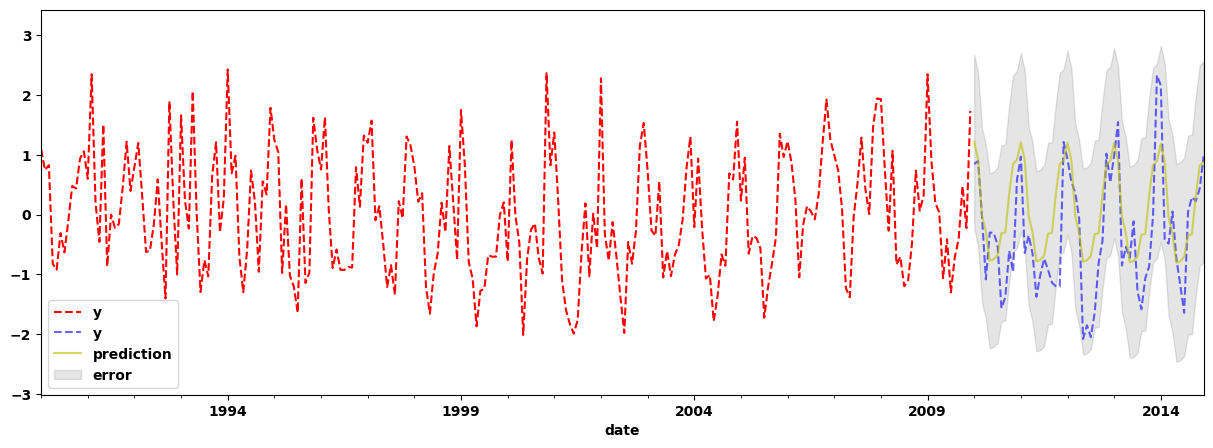

In [45]:
prediction = lf.predict(start=train.shape[0], end=train.shape[0] + test.shape[0] - 1)

pred1 = pd.concat([train, prediction.conf_int(), prediction.predicted_mean], axis=1)

fig, ax = plt.subplots(figsize=(15, 5))
ax = pred1['y'].plot(style='r--', label='y')

ax = test['y'].plot(style='b--', label='y', alpha=.6)

pred1['predicted_mean'].plot(style='y', alpha=.6, ax=ax, label='prediction')

ax.fill_between(pred1.index, pred1['lower y'], pred1['upper y'], alpha=.1, color='k', label='error') 

ax.set_ylim([pred1['y'].min()-1, pred1['y'].max()+1])

plt.legend()
plt.show()

###### Método iterativo

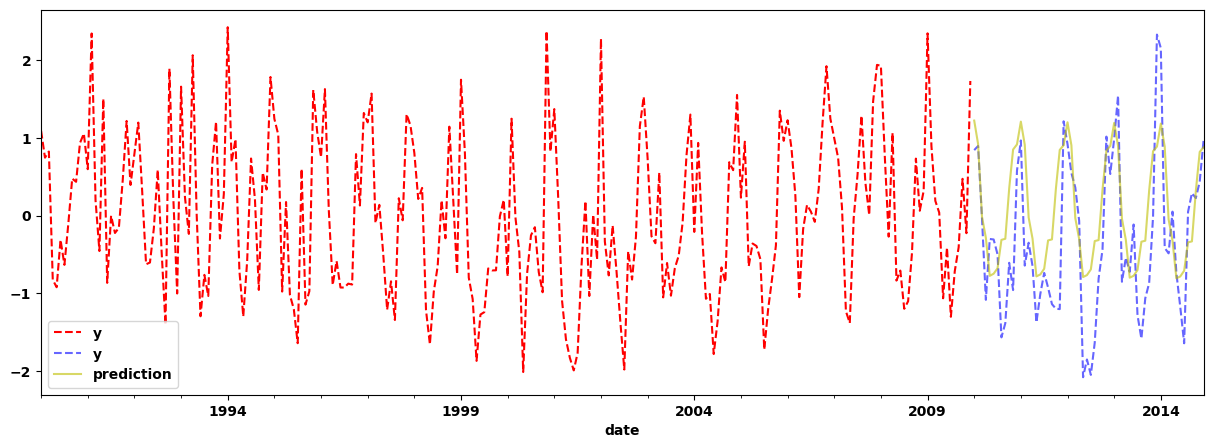

In [43]:
prediction = lf.predict_iter(train, horizon=60, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12), trend='n')

pred2 = test.copy()

pred2.iloc[:, 0] = prediction

fig, ax = plt.subplots(figsize=(15, 5))
ax = train['y'].plot(style='r--', label='y')

ax = test['y'].plot(style='b--', label='y', alpha=.6)

pred2['y'].plot(style='y', alpha=.6, ax=ax, label='prediction')


plt.legend()
plt.show()

##### Evaluación del error

In [55]:
lf.evaluate(test['y'], pred1['predicted_mean'].dropna())

{'MAPE': 2.1940740207735985, 'MAD': 0.6552869195428491}

In [56]:
lf.evaluate(test['y'], pred2['y'])

{'MAPE': 2.1943300902371776, 'MAD': 0.6553994981618181}

Tanto la predicción directa como la iterativa tienen un error parecido, no parece haber diferencia significativa. La que tiene menor error de predicción es la de predicción directa.

#### Estudiante 2: Kaleb Azael Ávila Padilla

In [ ]:
# Código de solución estudiante 2
.
.
.
.
